# Estimating rates and dates from time-stamped sequences
Data and models from the [BEAST documentation](https://beast.community/rates_and_dates),
though we tweak priors.

In [1]:
from treeflow import Alignment, AlignmentFormat

alignment = Alignment("demo-data/YFV.nex", format=AlignmentFormat.NEXUS)
alignment

Silencing TensorFlow...


Alignment(taxon_count=71, pattern_count=654)

In [2]:
from treeflow import parse_newick

starting_tree = parse_newick("demo-data/YFV.newick")
sequence_tensor = alignment.get_encoded_sequence_tensor(starting_tree.taxon_set)
sequence_tensor.shape

TensorShape([654, 71, 4])

We define a model using [TreeFlow's YAML model definition format](https://github.com/christiaanjs/treeflow/blob/master/docs/model-definition.md). We then parse this into a nested dictionary using Python's `yaml` library, and pass that to TreeFlow's `PhyloModel` class constructor. This class is converted into a TensorFlow Probability's `JointDistribution` using `phylo_model_to_joint_distribution`. This joint distribution class implements methods like `log_prob` and `sample`. The final statement of this code block examines the composition of samples from this joint distribution; it is a nested structure of Tensors which represent the variables of the model.

* TODO: Describe tree structure
* TODO: Mention dummy sampling

In [3]:
import yaml
import tensorflow as tf
from treeflow import (
    PhyloModel,
    convert_tree_to_tensor,
    phylo_model_to_joint_distribution
)

model_string = """
clock:
  strict:
    clock_rate:
      lognormal:
        loc: -2.0
        scale: 2.0
site:
  discrete_gamma:
    category_count: 4
    site_gamma_shape:
      lognormal:
        loc: 0.0
        scale: 1.0
substitution:
  hky:
    kappa:
      lognormal:
        loc: 1.0
        scale: 1.25
    frequencies:
      dirichlet:
        concentration:
        - 2.0
        - 2.0
        - 2.0
        - 2.0
tree:
  coalescent:
    pop_size:
      lognormal:
        loc: 1.0
        scale: 1.5
"""

model_dict = yaml.safe_load(model_string)
model = PhyloModel(model_dict)
starting_tensor_tree = convert_tree_to_tensor(starting_tree)
model_dist = phylo_model_to_joint_distribution(model, starting_tensor_tree, alignment)
model_dist_sample = model_dist.sample()
tf.nest.map_structure(lambda x: x.shape, model_dist_sample)

/home/christiaan/uni/treeflow/treeflow/distributions/tree/coalescent/constant_coalescent.py:133: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


StructTuple(
  pop_size=TensorShape([]),
  tree=TensorflowRootedTree(node_heights=TensorShape([70]), sampling_times=TensorShape([71]), topology=TensorflowTreeTopology(parent_indices=TensorShape([140]), child_indices=TensorShape([141, 2]), preorder_indices=TensorShape([141]))),
  kappa=TensorShape([]),
  frequencies=TensorShape([4]),
  clock_rate=TensorShape([]),
  site_gamma_shape=TensorShape([]),
  alignment=TensorShape([654, 71, 4])
)

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


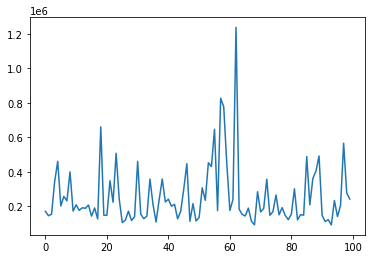

In [4]:
from treeflow.vi import fit_fixed_topology_variational_approximation, RobustOptimizer
from tqdm import tqdm
import matplotlib.pyplot as plt

model_dist_pinned = model_dist.experimental_pin(alignment=sequence_tensor)
optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.001))
num_steps = 30000
approx, (loss, approx_vars) = fit_fixed_topology_variational_approximation(
    model_dist_pinned,
    topologies=dict(tree=starting_tensor_tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=starting_tensor_tree),
    progress_bar=tqdm
)
plt.plot(loss)

### Try model with sequences partitioned into codon

In [5]:
codon_partitioned_sequence_tensor = alignment.get_codon_partitioned_sequence_tensor(starting_tree.taxon_set)
codon_partitioned_sequence_tensor.shape

TensorShape([3, 218, 71, 4])

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from treeflow.distributions import DiscretizedDistribution, SampleWeighted, DiscreteParameterMixture, LeafCTMC
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from treeflow.distributions.tree import ConstantCoalescent

codon_size = codon_partitioned_sequence_tensor.shape[0]
dist_dict = { dist.name: dist for dist in model_dist._get_single_sample_distributions() }

codon_size, codon_count, taxon_count, site_category_count = codon_partitioned_sequence_tensor.shape
subst_model = HKY()

def build_codon_alignment_distribution(kappa, frequencies, tree, clock_rate, site_gamma_shape):
    distance_tree = tree.get_unrooted_tree() * clock_rate
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfd.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        distance_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies,
        kappa=kappa
    )
    batch_ctmc = LeafCTMC(
        transition_probs_tree,
        tf.expand_dims(frequencies, -2) # Add a dimension to frequencies to broadcast with site rate mixture
    )
    site_rate_mixture = DiscreteParameterMixture(
        site_rate_distribution,
        batch_ctmc,
    )
    single_site_dist = tfd.Independent(site_rate_mixture, reinterpreted_batch_ndims=1)
    return tfd.Sample(
        single_site_dist,
        sample_shape=codon_count,
    )

codon_model_dist = tfd.JointDistributionNamed({
    "pop_size": dist_dict["pop_size"],
    "kappa": tfd.Sample(dist_dict["kappa"], sample_shape=codon_size),
    "frequencies": tfd.Sample(dist_dict["frequencies"], sample_shape=codon_size),
    "site_gamma_shape": dist_dict["site_gamma_shape"],
    "clock_rate": dist_dict["clock_rate"],
    "tree": lambda pop_size: ConstantCoalescent(starting_tensor_tree.taxon_count, pop_size, starting_tensor_tree.sampling_times, tree_name="tree"),
    "alignment": build_codon_alignment_distribution
})
codon_model_dist.event_shape

/home/christiaan/uni/treeflow/treeflow/distributions/tree/coalescent/constant_coalescent.py:133: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


{'pop_size': TensorShape([]),
 'tree': TensorflowRootedTree(node_heights=TensorShape([70]), sampling_times=TensorShape([71]), topology=TensorflowTreeTopology(parent_indices=TensorShape([140]), child_indices=TensorShape([141, 2]), preorder_indices=TensorShape([141]))),
 'site_gamma_shape': TensorShape([]),
 'kappa': TensorShape([3]),
 'frequencies': TensorShape([3, 4]),
 'clock_rate': TensorShape([]),
 'alignment': TensorShape([218, 3, 71, 4])}

In [7]:
site_first_codon_sequence_tensor = tf.transpose(codon_partitioned_sequence_tensor, [1, 0, 2, 3])
codon_model_dist_pinned = codon_model_dist.experimental_pin(alignment=site_first_codon_sequence_tensor)
codon_prior_sample = codon_model_dist.sample()
codon_prior_sample.pop("alignment")
codon_prior_sample["tree"] = starting_tensor_tree
codon_model_dist_pinned.log_prob(codon_prior_sample)

<tf.Tensor: shape=(), dtype=float64, numpy=-148825.42973550508>

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.39it/s]


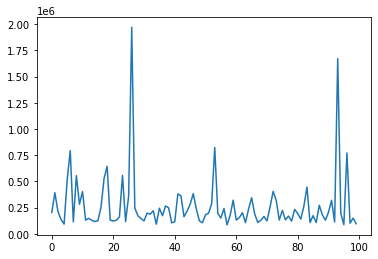

In [9]:
codon_optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.001))
codon_approx, (codon_loss, codon_approx_vars) = fit_fixed_topology_variational_approximation(
    codon_model_dist_pinned,
    topologies=dict(tree=starting_tensor_tree.topology),
    optimizer=codon_optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=starting_tensor_tree),
    progress_bar=tqdm,
    approx_kwargs=dict(var_name_prefix="codon_"),
)
plt.plot(codon_loss)